<ipython-input-1-d3a981061029>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Month=1, Predicted=48.864097, Expected=27.660000
Month=2, Predicted=31.421181, Expected=41.480000
Month=3, Predicted=35.907777, Expected=28.000000
Month=4, Predicted=32.633189, Expected=34.400000
Month=5, Predicted=34.172310, Expected=51.100000
Month=6, Predicted=41.762997, Expected=39.220000
Month=7, Predicted=40.887464, Expected=38.060000
Month=8, Predicted=44.140995, Expected=34.220000
Month=9, Predicted=42.879310, Expected=6.160000
Month=10, Predicted=26.873666, Expected=24.150000
Month=11, Predicted=17.355761, Expected=24.780000
Month=12, Predicted=26.068132, Expected=13.900000
Test RMSE: 14.648


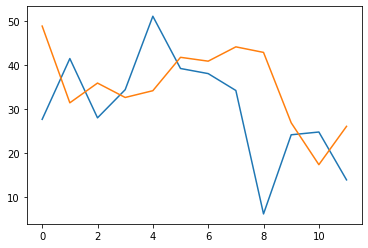

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
#	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences = True))
#	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences = True))
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='rmsprop')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# load dataset
series = read_csv('cbm_monthly_3dmovil.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1200, 2)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

<ipython-input-7-6c06cdb81688>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


1) Test RMSE: 24.884
2) Test RMSE: 39.448
3) Test RMSE: 18.198
4) Test RMSE: 26.744
5) Test RMSE: 15.488
6) Test RMSE: 23.964
7) Test RMSE: 42.423
8) Test RMSE: 24.140
9) Test RMSE: 60.652
10) Test RMSE: 24.089
11) Test RMSE: 28.912
12) Test RMSE: 23.539
13) Test RMSE: 43.710
14) Test RMSE: 13.713
15) Test RMSE: 24.003
16) Test RMSE: 22.032
17) Test RMSE: 27.805
18) Test RMSE: 13.402
19) Test RMSE: 28.056
20) Test RMSE: 13.376
21) Test RMSE: 23.315
22) Test RMSE: 18.956
23) Test RMSE: 22.810
24) Test RMSE: 31.618
25) Test RMSE: 15.827
26) Test RMSE: 19.485
27) Test RMSE: 27.067
28) Test RMSE: 17.078
29) Test RMSE: 15.997
30) Test RMSE: 19.596
            rmse
count  30.000000
mean   25.010945
std    10.334286
min    13.376297
25%    18.387806
50%    23.751708
75%    27.620966
max    60.651757


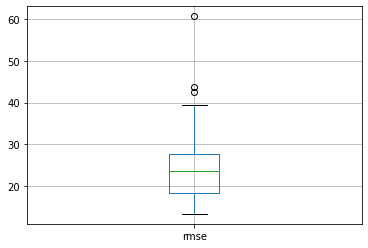

In [7]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# load dataset
series = read_csv('cbm_monthly_3dmovil.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
#series = read_csv('quantity_weekly_3dmovil.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	#lstm_model = fit_lstm(train_scaled, 1, 100, 100)
	lstm_model = fit_lstm(train_scaled, 1, 1200, 2)
	#lstm_model.save('lstm_cbm_sequential_rmsprop_'+str(r+1)+'.h5')
	lstm_model.save('lstm_cbm_sequential_adam_'+str(r+1)+'.h5')
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)
 
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (1, 2)                    32        
_________________________________________________________________
dense_26 (Dense)             (1, 1)                    3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


<ipython-input-2-377103c7c93a>:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


dict_keys(['loss'])


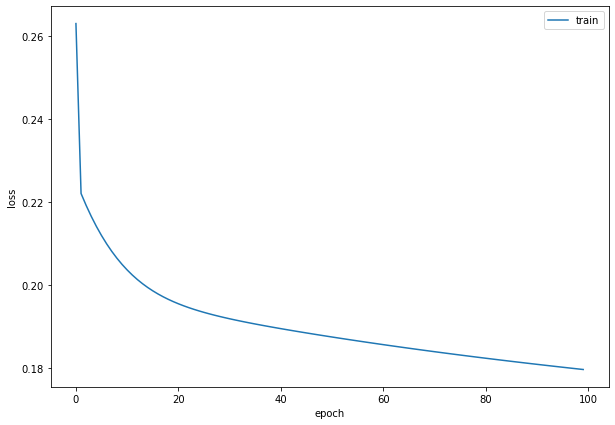

In [2]:
from keras.models import load_model
#new_model = load_model('lstm_sequential_30.h5') #RMSE 202
#new_model = load_model('lstm_sequential_rmsprop_10.h5')
new_model = load_model('lstm_cbm_sequential_rmsprop_23.h5')

new_model.summary()

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import matplotlib.pyplot as plt

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# load dataset
series = read_csv('cbm_monthly_3dmovil.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
#series = read_csv('quantity_weekly_3dmovil.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
     
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

X, y = test_scaled[:, 0:-1], test_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])


#from keras.preprocessing.sequence import TimeseriesGenerator
#generator = TimeseriesGenerator(X, X, length=12, batch_size=1)#definimos los batches
#generator[0]
#new_model.fit_generator(generator,epochs=50)
history = new_model.fit(X, y, epochs=100, batch_size=1, verbose=0, shuffle=False)
print(history.history.keys())

#loss_per_epoch = new_model.history.history['loss']
#plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
#plt.plot(history.history['loss'])
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history.history['loss'])
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

<ipython-input-1-737070b4c550>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


,Model,MSE,RMSE,AIC,BIC
0,lstm_cbm_sequential_rmsprop_22.h5,44.852618,6.697210,115.640583,132.612316
1,lstm_cbm_sequential_rmsprop_23.h5,45.295895,6.730222,115.758597,132.730330
2,lstm_cbm_sequential_rmsprop_4.h5,48.955455,6.996817,116.690930,133.662662
3,lstm_cbm_sequential_rmsprop_27.h5,49.463204,7.033008,116.814748,133.786481
4,lstm_cbm_sequential_rmsprop_5.h5,52.568712,7.250428,117.545453,134.517186
5,lstm_cbm_sequential_rmsprop_18.h5,55.543098,7.452724,118.205911,135.177644
6,lstm_cbm_sequential_rmsprop_19.h5,56.483948,7.515580,118.407478,135.379211
7,lstm_cbm_sequential_rmsprop_25.h5,58.556803,7.652242,118.839967,135.811700
8,lstm_cbm_sequential_rmsprop_11.h5,62.143542,7.883118,119.553363,136.525096
9,lstm_cbm_sequential_rmsprop_2.h5,65.957073,8.121396,120.268049,137.239782


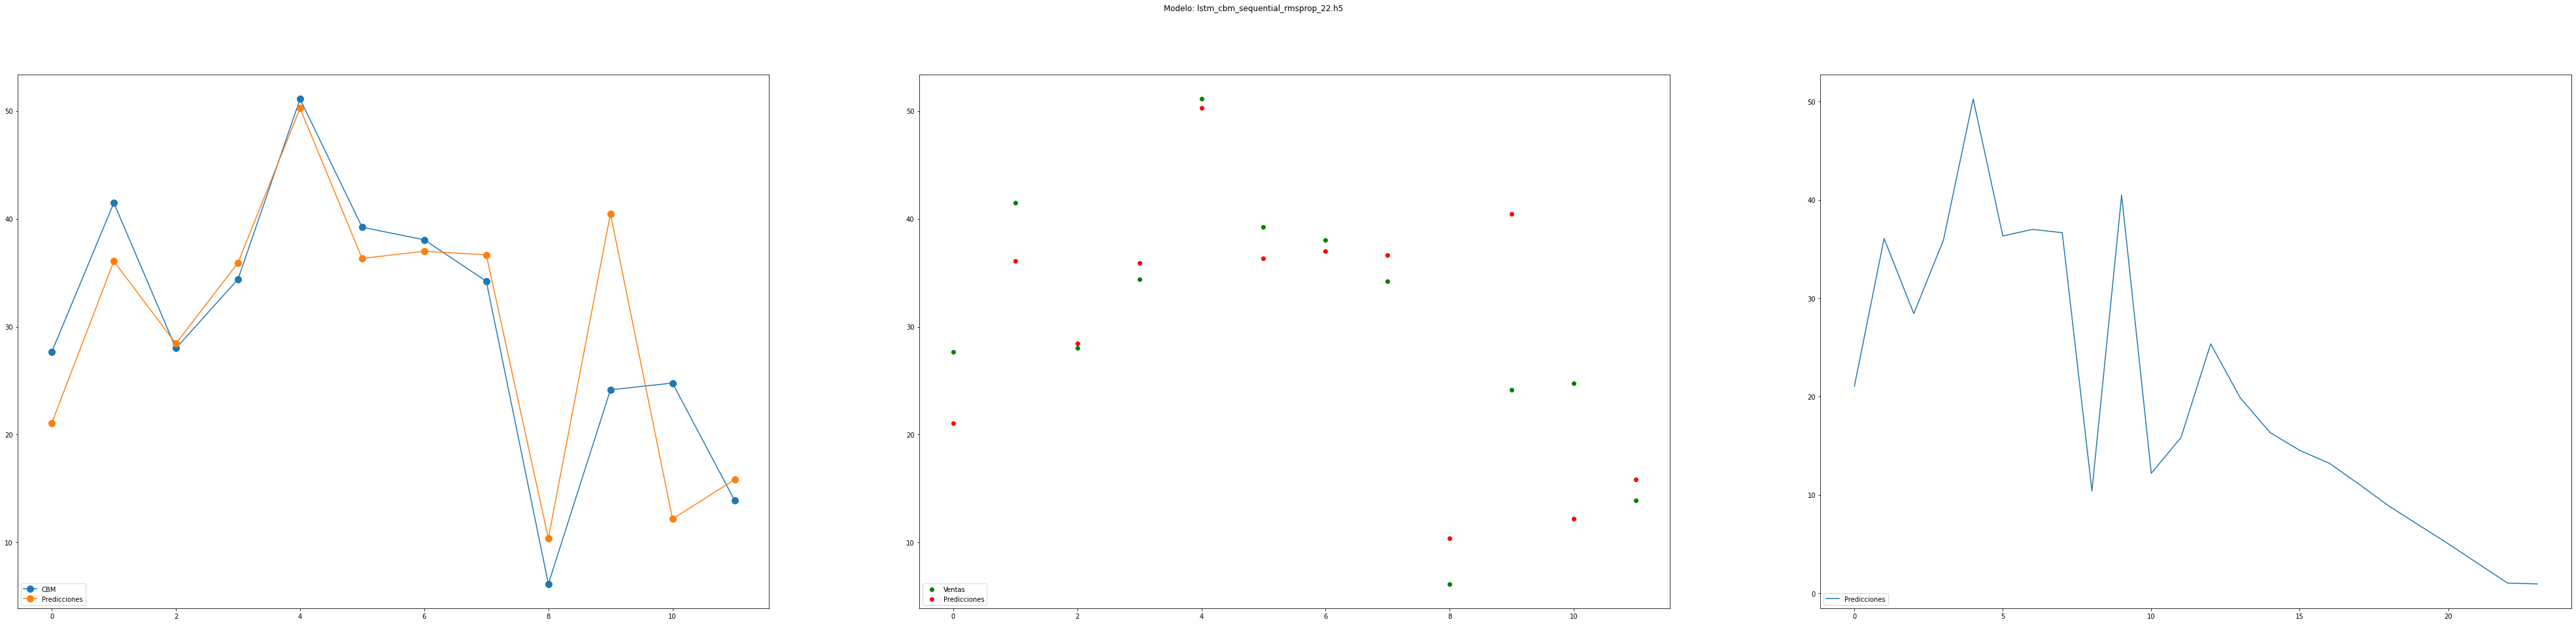

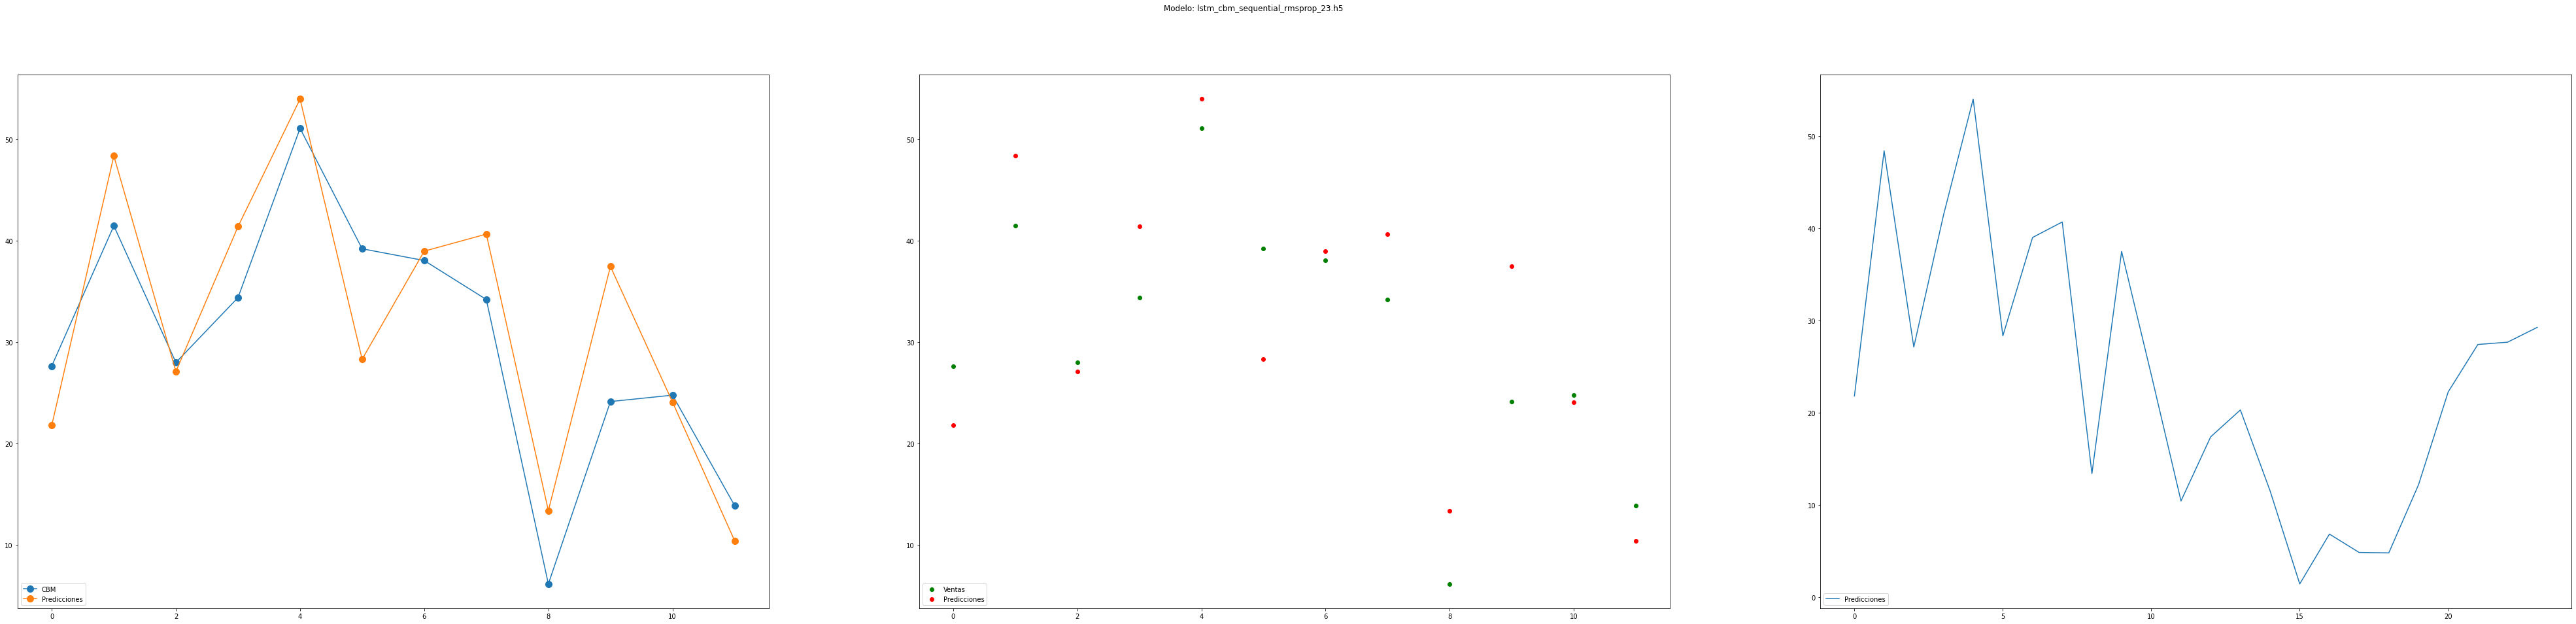

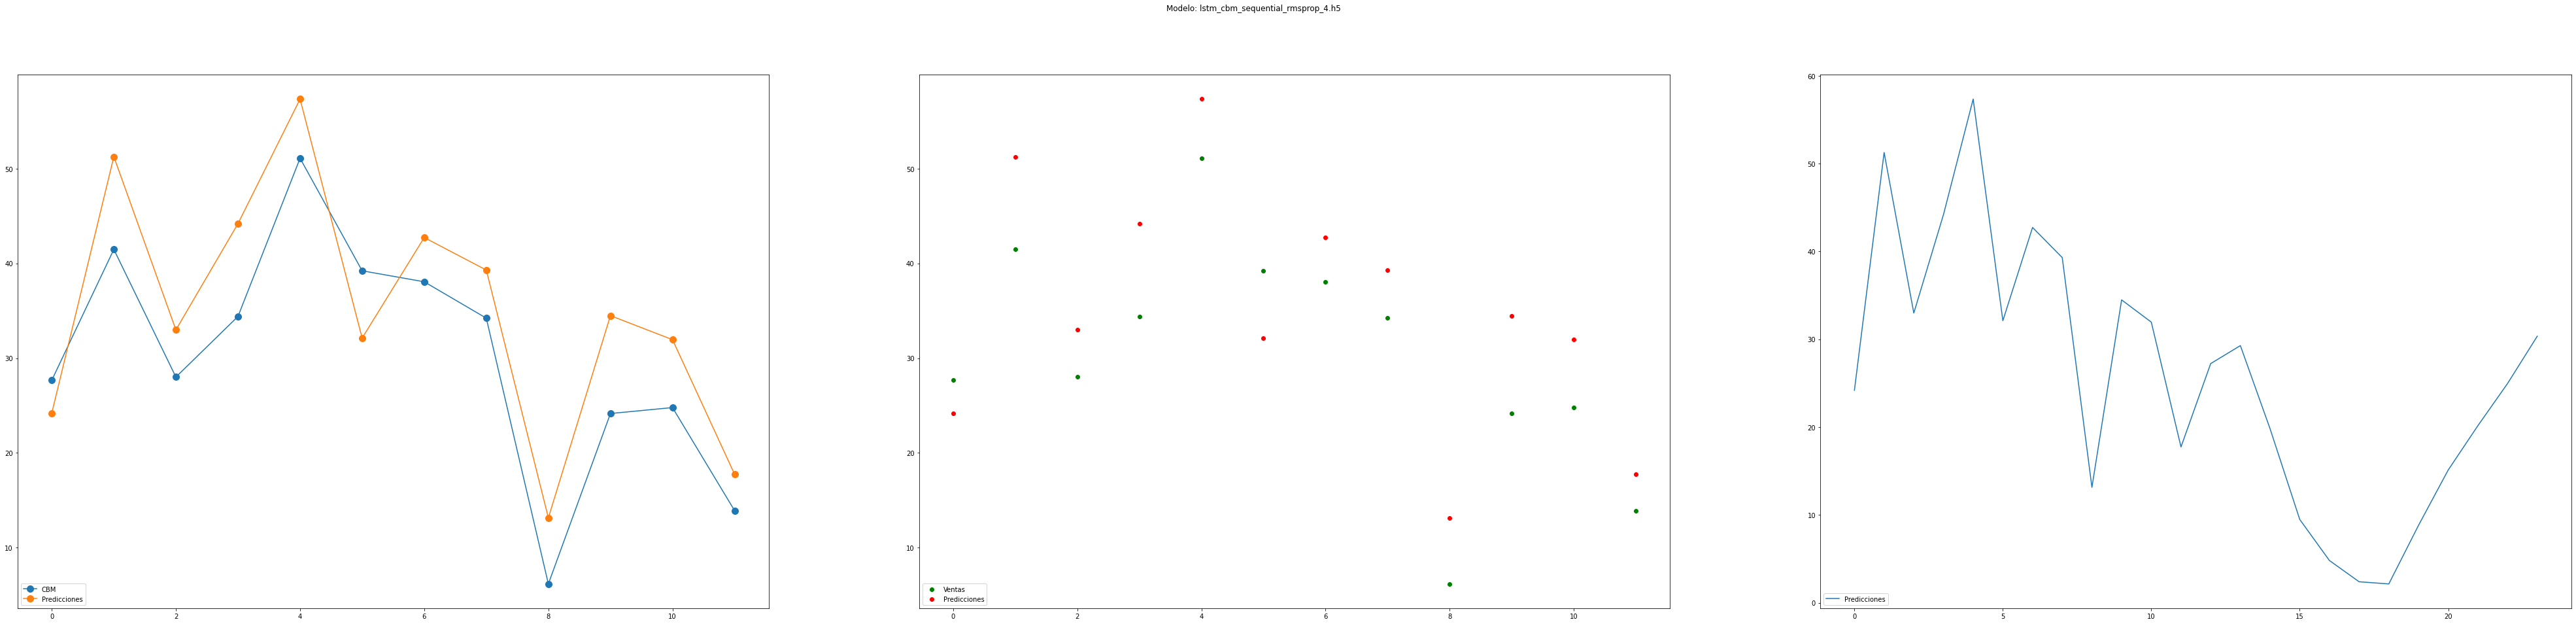

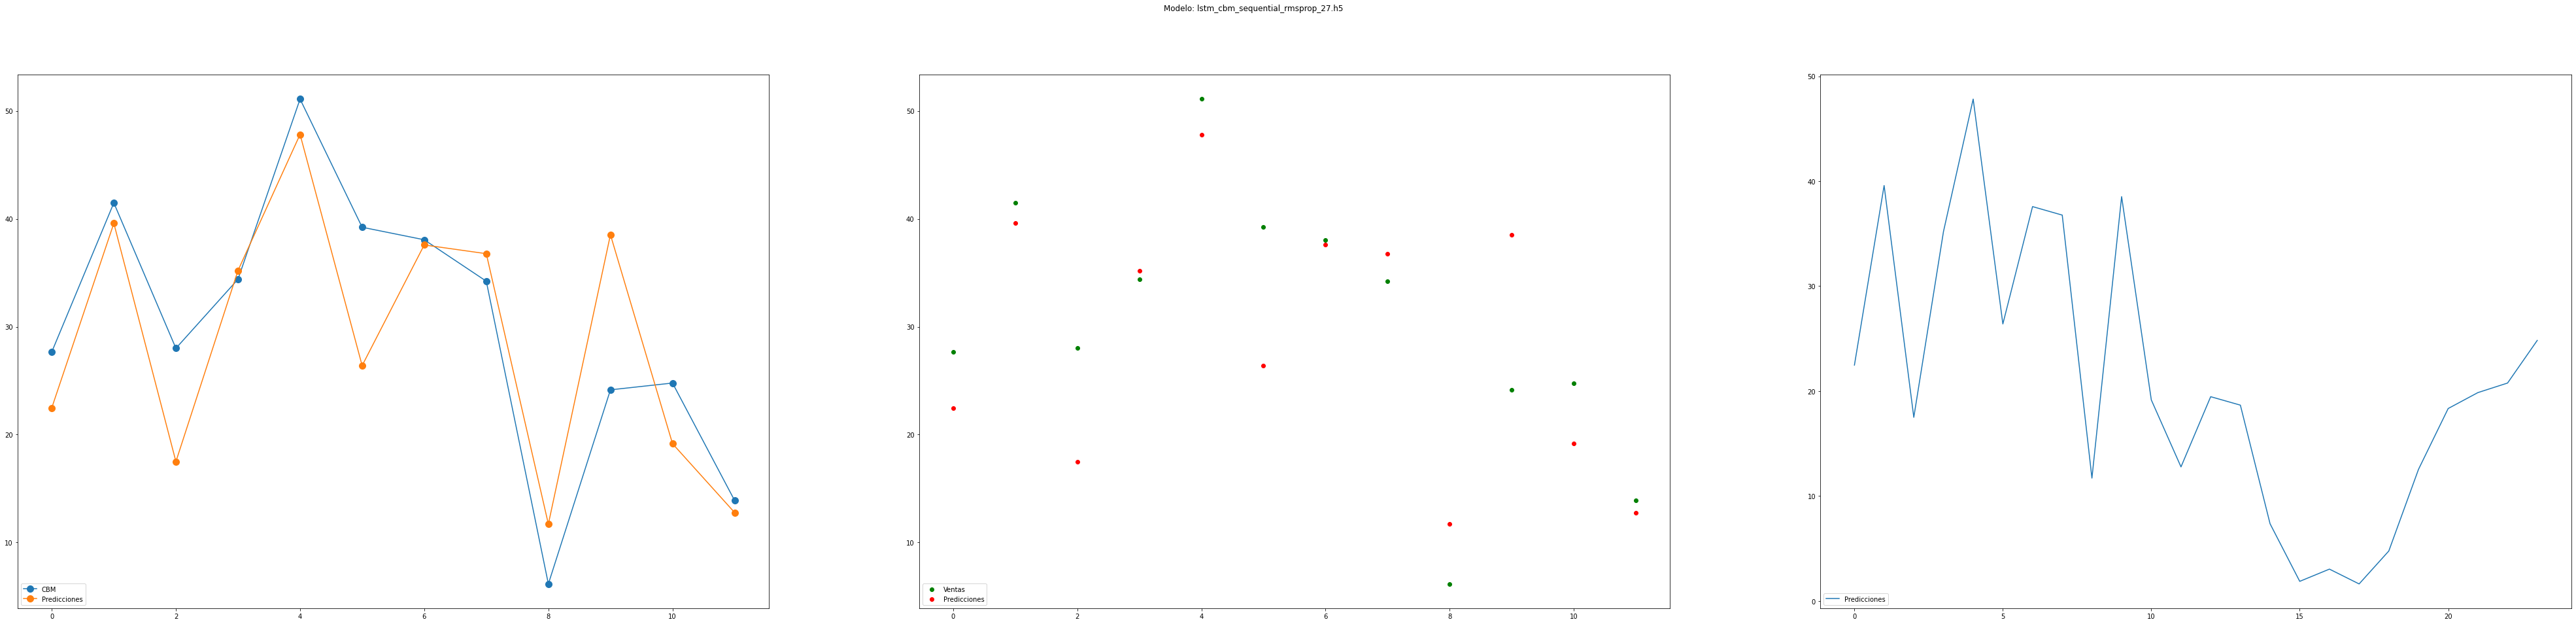

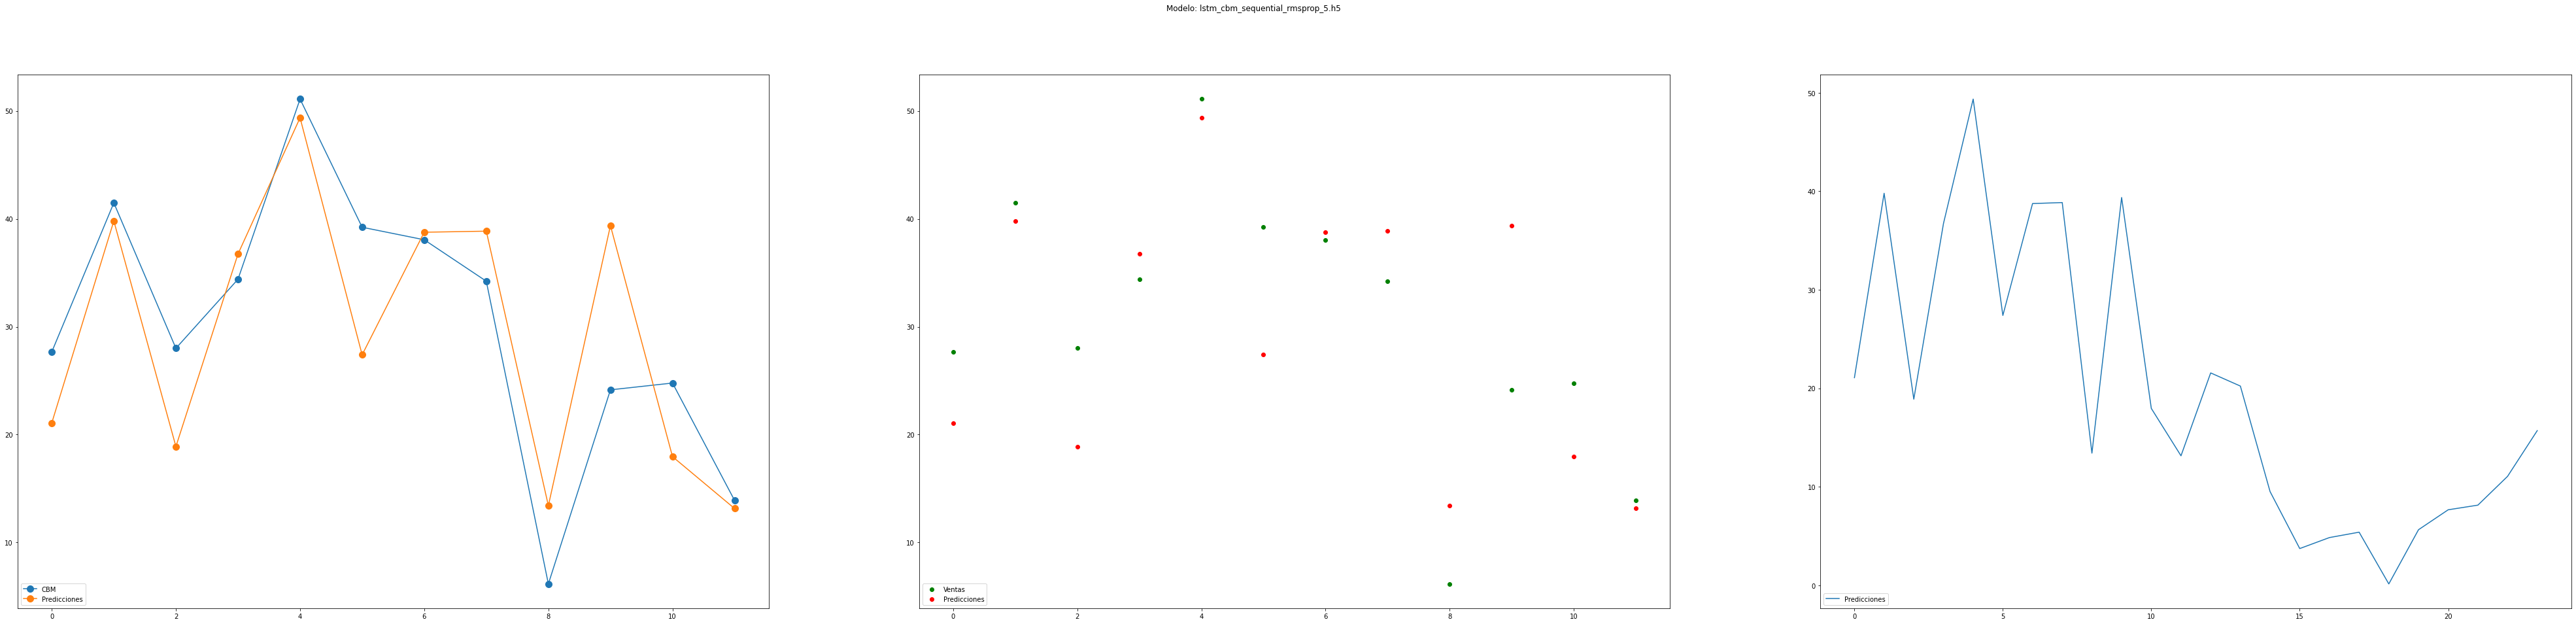

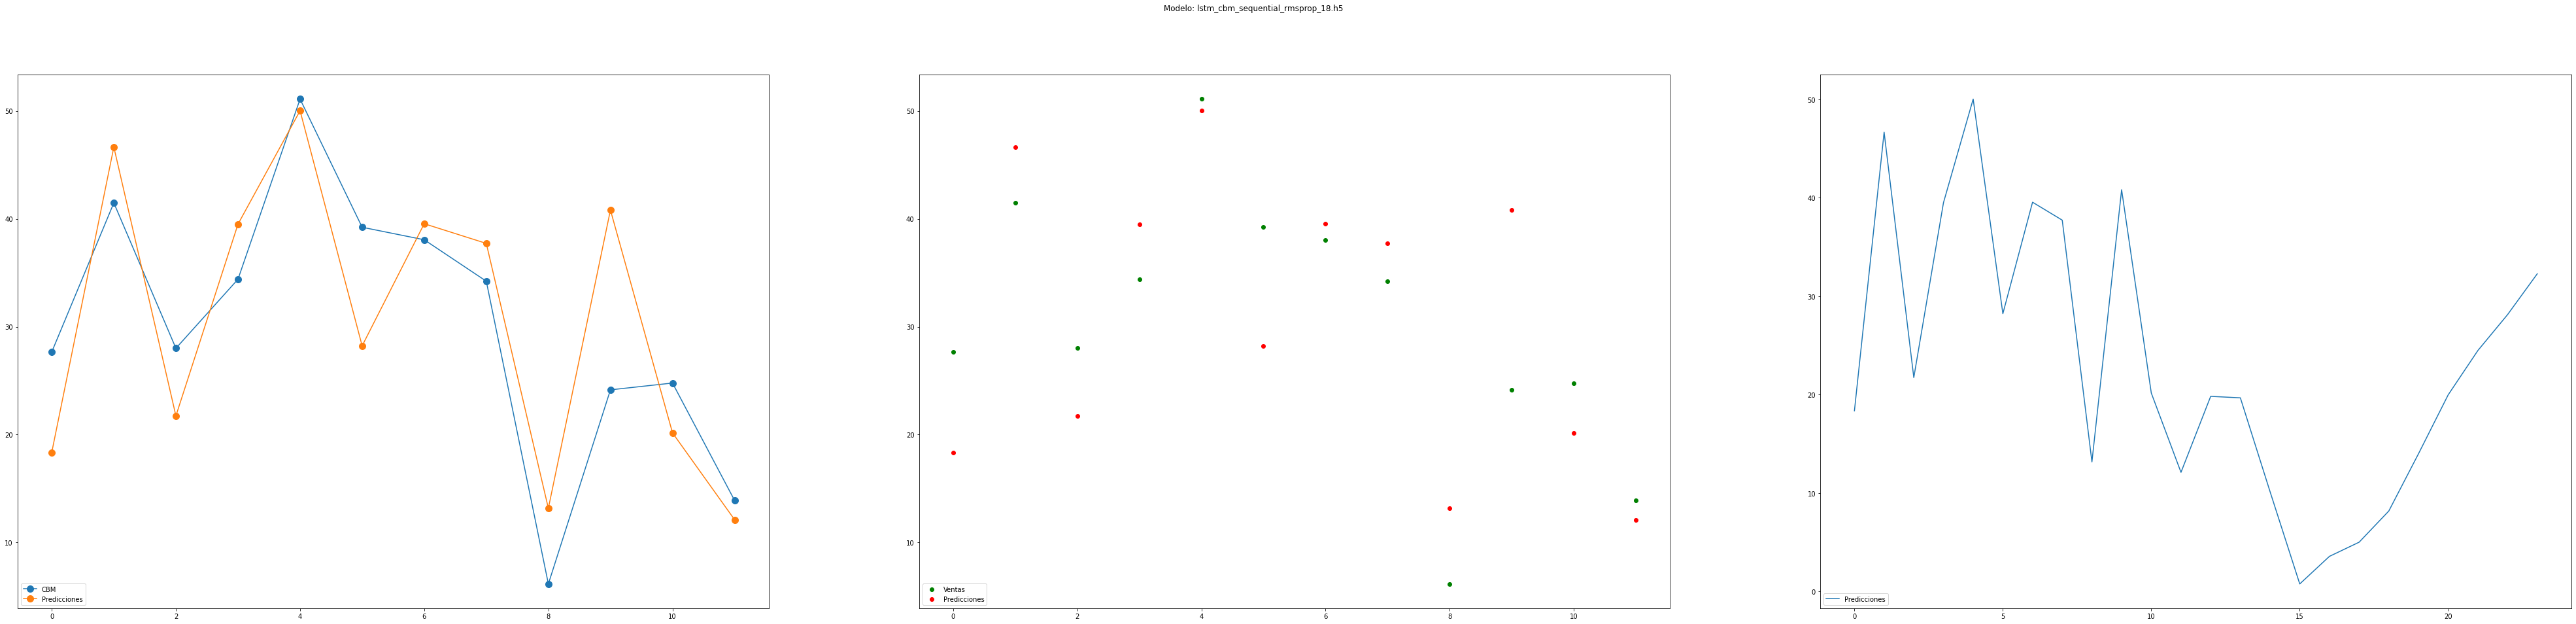

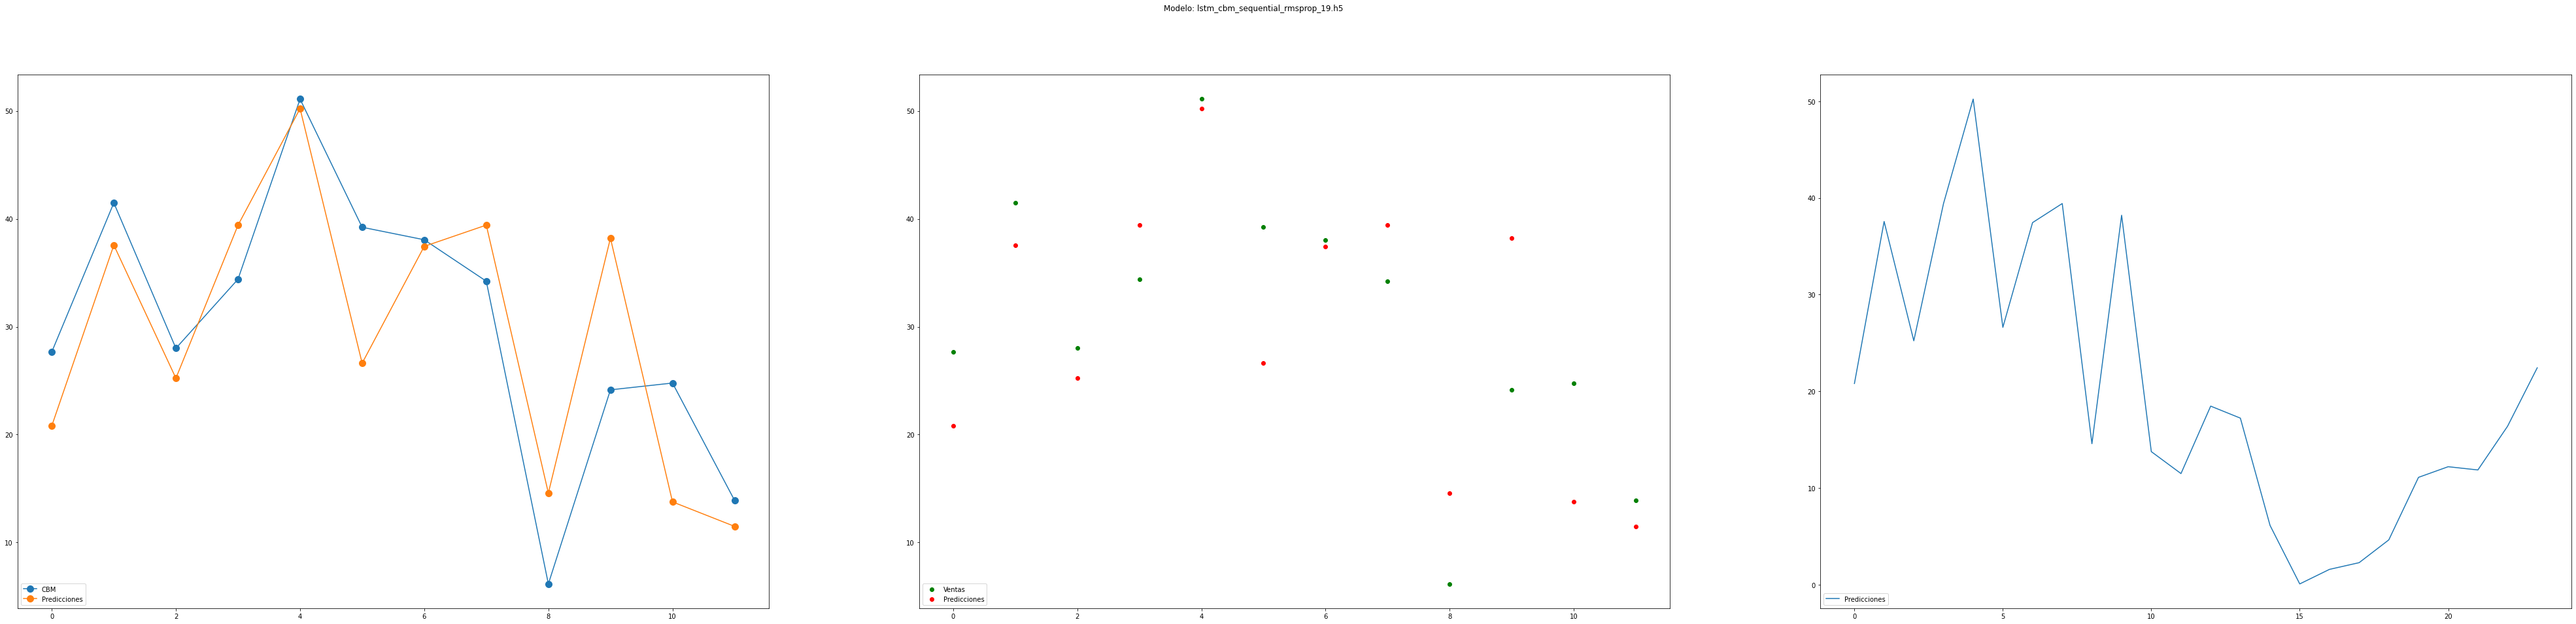

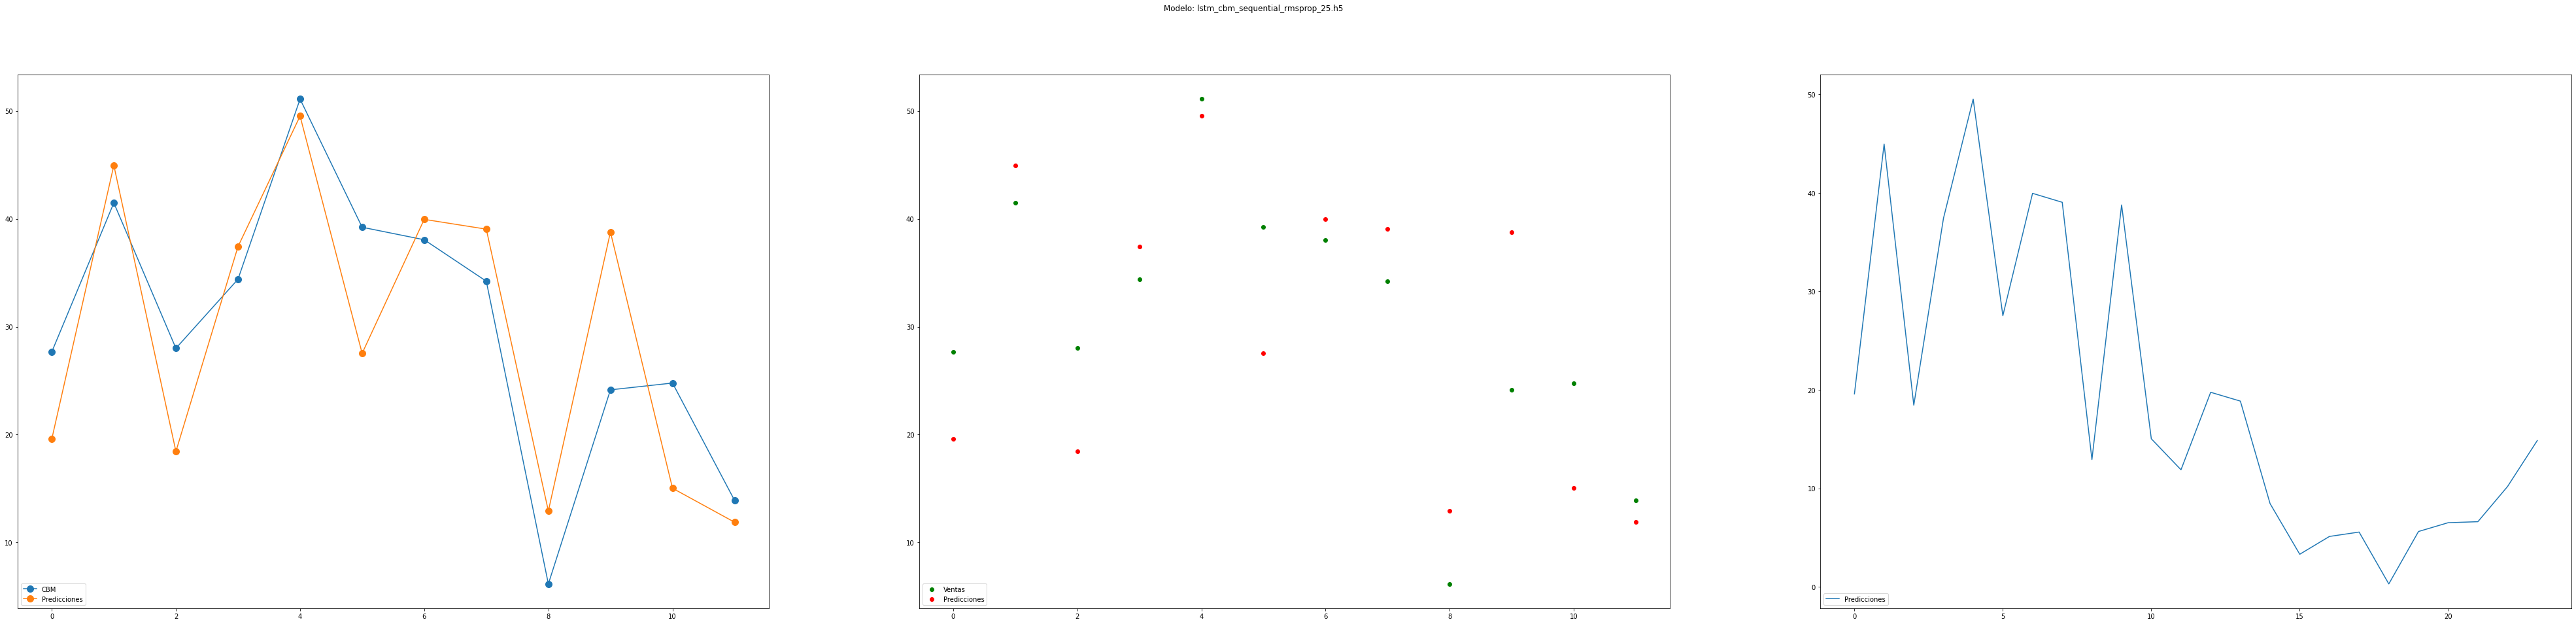

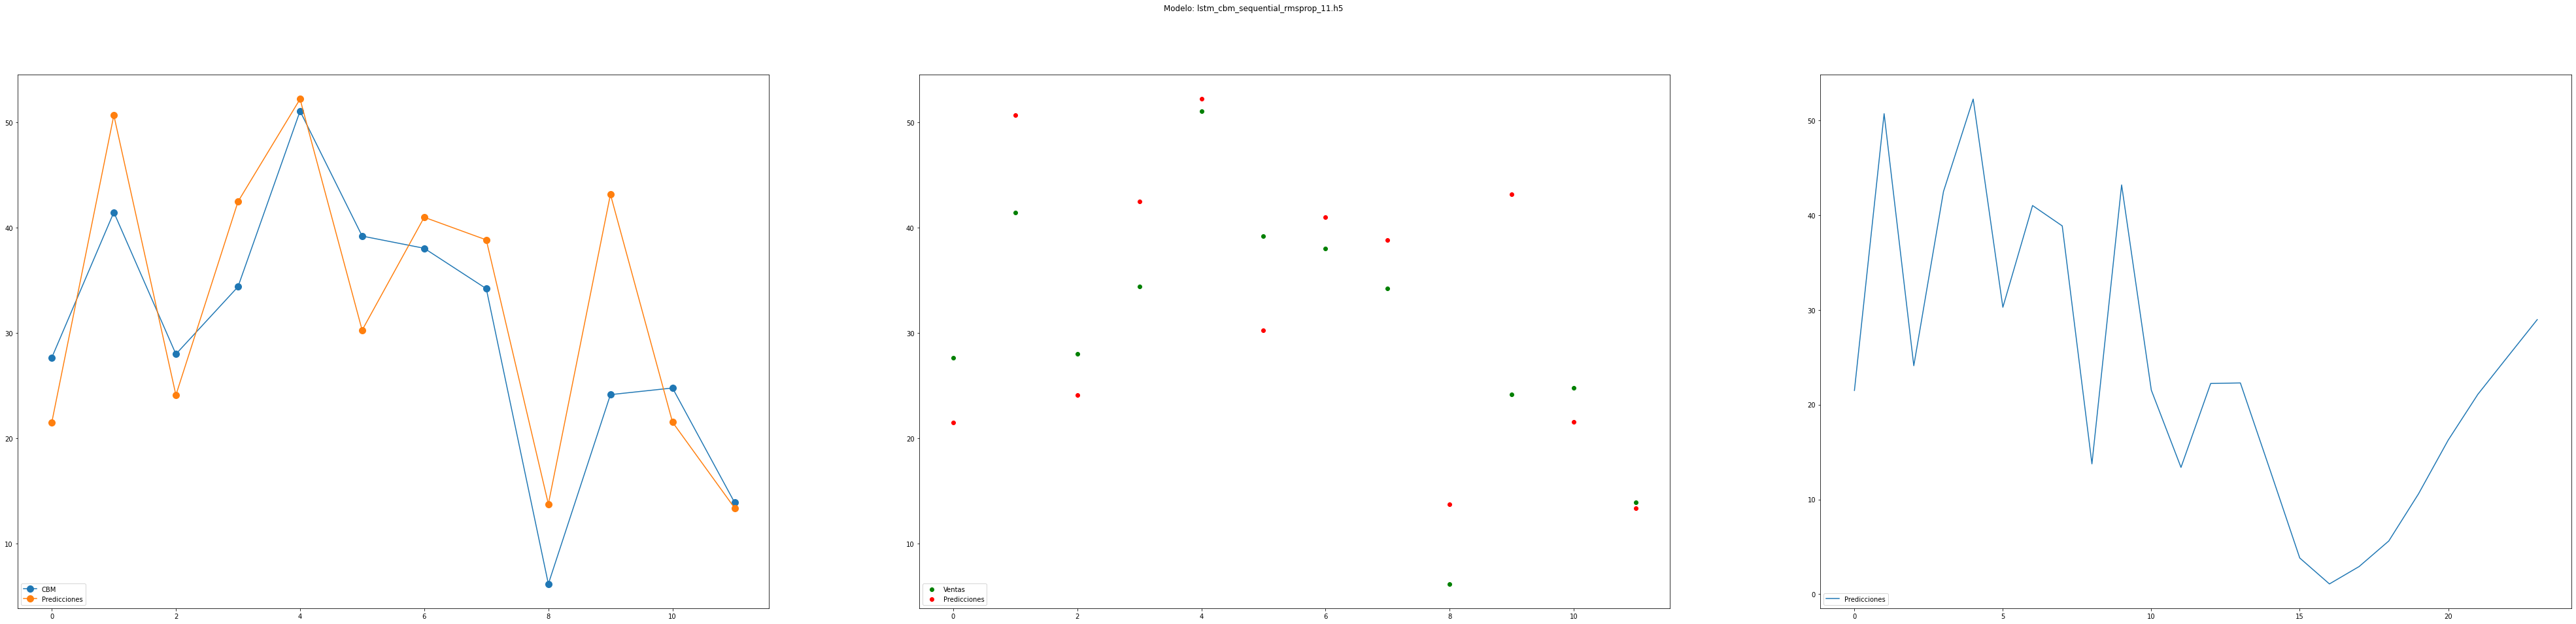

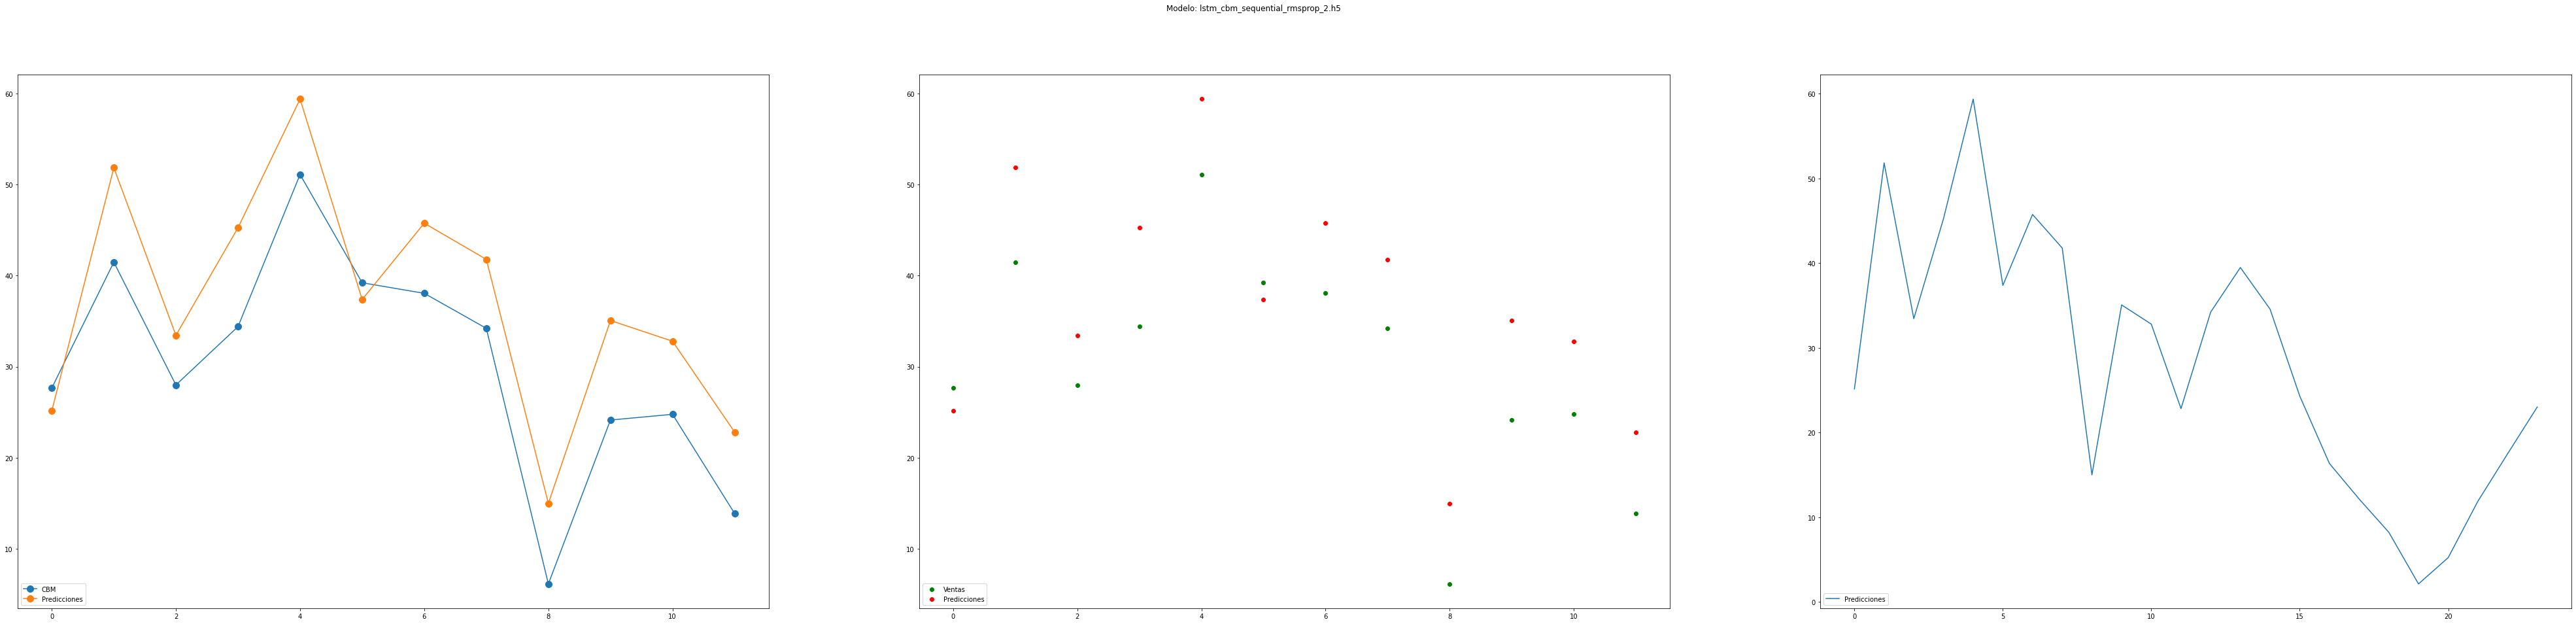

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt,log
from matplotlib import pyplot
import numpy
from keras.models import load_model
import glob
from operator import itemgetter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# calculate aic for regression
def calculate_aic(n, mse, num_params):
	aic = n * log(mse) + 2 * num_params
	return aic

# num_params: Number of parameters (weights and biases)
# n: Number of training cases
def calculate_bic(n, mse, num_params):
	bic = n * log(mse) + num_params * log(n)
	return bic

series = read_csv('cbm_monthly_3dmovil.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
#print(series.index)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 


# All files starting with lstm
files = glob.glob("lstm_cbm_sequential_*")
metrics = list()
for file in files:

    new_model = load_model(file)
    
    predictions = list()
    predictions2 = list()
    expectedSales = list()
    raw_values2 = series.values
    ntest = len(test)-1
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    for i in range(24):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        #print(X)    
        yhat = forecast_lstm(new_model, 1, X)
        #print("prediccion: %.3f" %yhat)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values2, yhat, len(test_scaled)-i)
        # store forecast
        predictions.append(yhat)
        predictions2.append(abs(yhat))

        expected = [raw_values2[len(train) + i + 1],0][i>ntest]
        expectedSales.append(expected)

        raw_values2 = [[raw_values2,
                        np.append(raw_values2,[yhat])][i==ntest]
                       ,np.append(raw_values2,[yhat])][i>ntest]
        #print(raw_values2)
        diff_values2 = difference(raw_values2, 1)
        #print(diff_values2)
        supervised2 = timeseries_to_supervised(diff_values2, 1)
        supervised_values2 = supervised2.values
        train2, test2 = supervised_values2[0:-12], supervised_values2[-12:]
        scaler2, train_scaled2, test_scaled2 = scale(train2, test2)
        test_scaled = [[test_scaled,
                        np.append(test_scaled,[test_scaled2[11,0:]],axis=0)][i==ntest]
                       ,np.append(test_scaled,[test_scaled2[11,0:]],axis=0)][i>ntest]

    mse = mean_squared_error(raw_values[-12:], predictions[:12])
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions[:12]))
    aic = calculate_aic(len(raw_values[-12:]), mse, new_model.count_params())
    bic = calculate_bic(len(raw_values[-12:]), mse, new_model.count_params())

    metrics.append([file,mse,rmse,aic,bic,predictions,predictions2,expectedSales,series.index])
#print('MSE: %.3f' % mse)
#print('RMSE: %.3f' % rmse)   
#print('AIC: %.3f' % aic)
#print('BIC: %.3f' % bic)
    

metrics = sorted(metrics, key=itemgetter(2))
#print(metrics)


for metric in metrics[:10]:

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(15)
    fig.set_figwidth(70)
    fig.suptitle("Modelo: "+ metric[0])
    ax1.plot(raw_values[-12:], label='CBM', marker = 'o', markersize = 10)
    ax1.plot(metric[5][:12], label='Predicciones', marker = 'o', markersize = 10)
    ax1.legend(loc="lower left")
    ax2.scatter(range(len(raw_values[-12:])),raw_values[-12:],c='g', label='Ventas')
    ax2.scatter(range(len(metric[5][:12])),metric[5][:12],c='r', label='Predicciones')
    ax2.legend(loc="lower left")
    ax3.plot(metric[6], label='Predicciones')
    ax3.legend(loc="lower left")
    
    
df = pd.DataFrame(metrics[:10],columns=['Model', 'MSE', 'RMSE', 'AIC', 'BIC', 'predictions', 'predictions2','expected','fechas'])
df2 =df[['Model', 'MSE', 'RMSE', 'AIC', 'BIC']]
df2

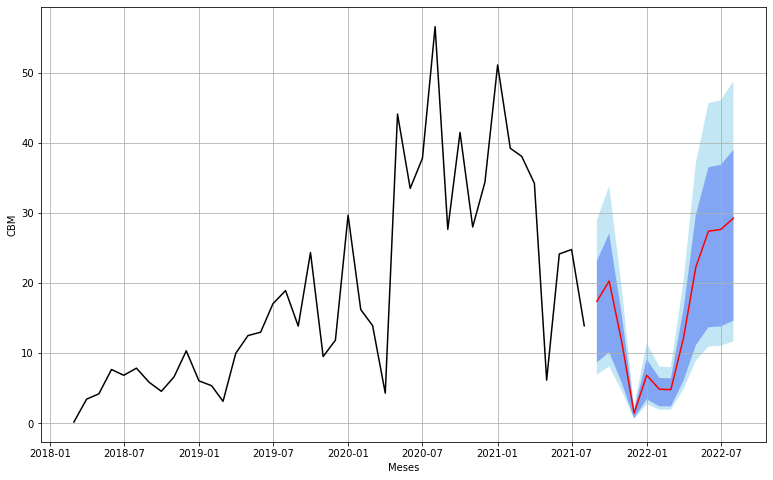

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

sales_df = pd.read_csv('cbm_monthly_3dmovilcopia.csv',index_col='Month',parse_dates=True)
sales_df.index = pd.date_range('2018-03-01', periods=54, freq="MS")

newlist = sales_df.Cbm[42:54].to_numpy()

X1 = newlist

fig, ax = plt.subplots(1,figsize=(13,8))
ax.plot(sales_df.index[0:42],sales_df.Cbm[0:42], color ="black")

ax.plot(sales_df.index[42:54],sales_df.Cbm[42:54], color ="red")

ax.fill_between(sales_df.index[42:54],(X1/1.5)*2, X1/2, facecolor='blue', alpha=0.5)
ax.fill_between(sales_df.index[42:54],(X1/1.5)*2.5, X1/2.5, facecolor='skyblue', alpha=0.5)
ax.set_xlabel('Meses')
ax.set_ylabel('CBM')
ax.grid()

In [4]:

prediccion = list(df.predictions[1]) #lstm_cbm_sequential_rmsprop_23
meses = list(df.fechas[1])
expected = list(df.expected[1])
columns = ['Mes', 'Prediccion', 'Expected']

new = pd.DataFrame(np.column_stack([meses[-12:], prediccion[:12],expected[:12]]), index=[meses[-12:]], columns=columns)
new


,Mes,Prediccion,Expected
2020-09-30,2020-09-30,21.802037,27.66
2020-10-31,2020-10-31,48.379312,41.48
2020-11-30,2020-11-30,27.111877,28.0
2020-12-31,2020-12-31,41.403465,34.4
2021-01-31,2021-01-31,53.987309,51.1
2021-02-28,2021-02-28,28.324848,39.22
2021-03-31,2021-03-31,38.98532,38.06
2021-04-30,2021-04-30,40.667346,34.22
2021-05-31,2021-05-31,13.396876,6.16
2021-06-30,2021-06-30,37.471724,24.15


In [5]:
my_range = pd.date_range(
  start="2020-09-30", end="2022-08-31", freq='M')

prediccion = list(df.predictions2[1])
columns = ['Prediccion']
new = pd.DataFrame(np.column_stack([prediccion[-24:]]), index=[my_range], columns=columns)
new

,Prediccion
2020-09-30,21.802037
2020-10-31,48.379312
2020-11-30,27.111877
2020-12-31,41.403465
2021-01-31,53.987309
2021-02-28,28.324848
2021-03-31,38.985320
2021-04-30,40.667346
2021-05-31,13.396876
2021-06-30,37.471724


In [62]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define EOQ function
def EOQ(S, D, H, L):

    """
    Economic Order Quantity
    
    Arguments:
    S: ordering cost
    D: annual quantity demanded
    H: holding cost per unit
    L: tiempo de espera
  
    Returns:
    [Q, number_of_orders, time_between_cycles, annual ordering cost, annual holding cost, annual total cost, t*0]
    
    Q: politica de inventario optima (Y*)
    number_of_orders: Número esperado de ordenes
    time_between_cycles: tiempo entre ciclos - dias
    annual ordering cost:
    annual holding cost:
    annual total cost: costo de inventario diario asociado a la politica propuesta (TCU)
    
    t*0: duración del ciclo asociado - dias
    Le: tiempo de espera efectivo
    n: numero de ciclos incluidos en L
    """

    # Validate that all function arguments are non-negative
    if(S>0 and D>0 and H>0):

        Q = (np.sqrt(2*S*D/H))
        print("Q: %.3f" % Q)
        number_of_orders = D/Q
        print("Numero de ordenes al año: %.3f" % number_of_orders)
        time_between_cycles = 12/number_of_orders
        print("tiempo entre ciclos: %.3f" % time_between_cycles)
        AOC = D/Q*S
        AHC = Q/2*H
        ATC = AOC+AHC
        print("TCU: %.3f" % ATC)
        print("-------------------")
        t0 = Q/D
        print("t0: %.3f" % t0)
        n = round(L/t0)
        print("n: %.3f" % n)
        Le = L - (n*t0)
        print("L: %.3f" % L)
        print("Le: %.3f" % Le)
        reorderPoint = Le*D
        print("Punto de reorden: %.3f" % reorderPoint)

        #return [Q, number_of_orders, time_between_cycles, AOC, AHC, ATC, t0, reorderPoint]

    else:    
        print("Error. All function arguments must be non-negative.")
        
# Run example    
#EOQ(100,100,0.02,12)
#EOQ(1500,10000,0.02,35)
#EOQ(813,1127,0.05,45)
#EOQ(500,195,0.05,45)
"""
La demanda proyectada (D) es de 5587 unidades por año.
El costo de ordenar en base a datos historicos (S) es 813.11 por pedido.
El costo anual de mantener (H) por unidad es 0.15 por unidad
Días de trabajo al año: 240 días.
Tiempo de espera en cada pedido: 45 dias

Q: cantidad óptima de pédido: 7782 / 12 = 648.5 unidades mensuales
N: cantidad de veces que se deberá ordenar en el año: 0.71 * 12 = 8 pedidos al año
L: lead time o el tiempo entre una orden calculado: (240/0.71) = 338.02 / 12 = 28 dias
R: punto de reorden : 2366 / 12 = 197 unidades al mes
TCU: costo de inventario diario asociado a la politica propuesta : 1167
Tiempo entre ciclos = 17, es decir se debera esperar 17 dias en cada pedido a provedores
"""
EOQ(813.11,5587,0.15,45)

Q: 7782.755
Numero de ordenes al año: 0.718
tiempo entre ciclos: 16.716
TCU: 1167.413
-------------------
t0: 1.393
n: 32.000
L: 45.000
Le: 0.424
Punto de reorden: 2366.842


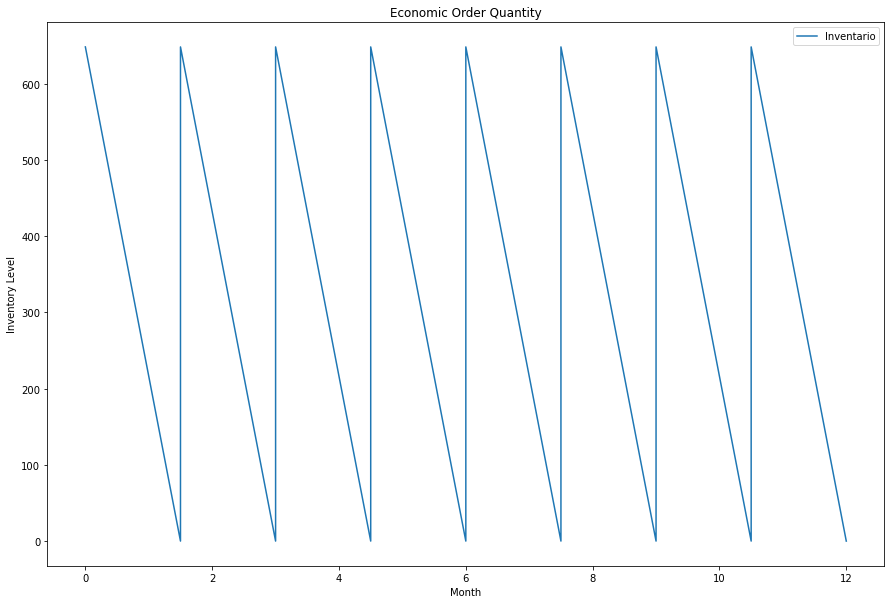

In [730]:
# Create period list and append values
period = [0, 1.5]
#print(period[-1])
while period[-1] < 12:
    period.append(period[-1])
    period.append(period[-1]+1.5)
#print(period)    
# Create inventory list and append values
inventory = [648.5, 0]
while len(inventory) < len(period):
    inventory.append(648.5)
    inventory.append(0)

# Plot inventory level graph
plt.figure(figsize=(15,10))
plt.plot(period,inventory,label="Inventario")
#plt.axhline(197, linestyle="dashed", color="r", label="Punto de reorden")
plt.xlabel("Month")
plt.ylabel("Inventory Level")
plt.title("Economic Order Quantity")
plt.legend()

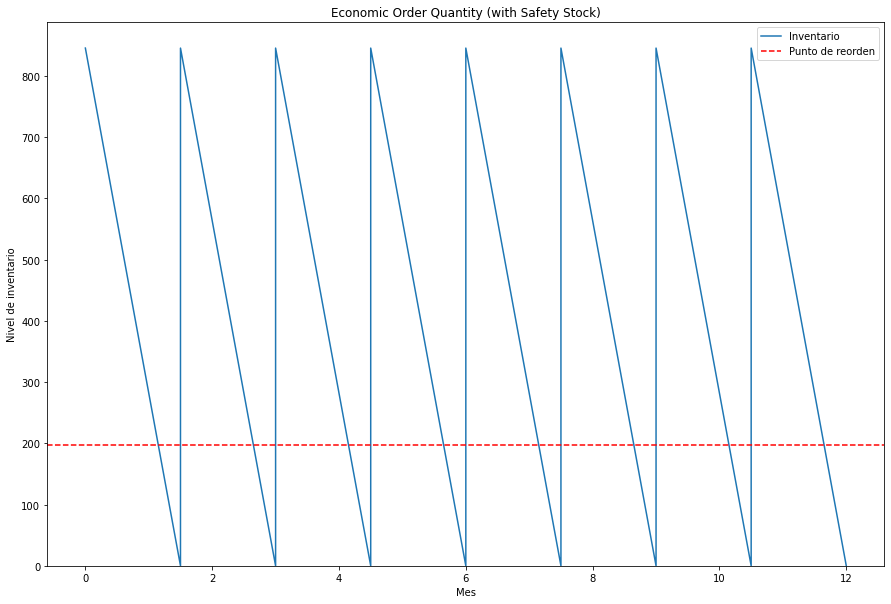

In [731]:
# Set safety stock
safety_stock = 197

# Create inventory list and append values
#inventory_with_ss = [648.5 + safety_stock, safety_stock]
inventory_with_ss = [648.5 + safety_stock, 0]
while len(inventory_with_ss) < len(period):
    inventory_with_ss.append(648.5 + safety_stock)
    #inventory_with_ss.append(safety_stock)
    inventory_with_ss.append(0)
  
# Plot inventory level graph
plt.figure(figsize=(15,10))
plt.plot(period,inventory_with_ss, label="Inventario")
plt.axhline(safety_stock, linestyle="dashed", color="r", label="Punto de reorden")
plt.xlabel("Mes")
plt.ylabel("Nivel de inventario")
plt.ylim(0)
plt.title("Economic Order Quantity (with Safety Stock)")
plt.legend()